We learn sets in the form {2,5,3,8}

$\forall \pi \in \mathcal{P}_n, F(\pi X) = F(X)$

Function is permutation invariante iif it can be written in the form $\psi(\sum_{x \in X} \phi (x))$. We use two MLPs to learn $\psi$ and $\phi$.

In this lab we deal with multi-sets (not sets with unique elements)

Padding: to use LSTM

### Utils

In [1]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
"""

import numpy as np


def create_train_dataset():
    n_train = 100000
    max_train_card = 10

    ############## Task 1

    ##################
    X_train = np.zeros((n_train,max_train_card))
    y_train = np.zeros(n_train)

    for i in range(n_train):
      card = np.random.randint(1,max_train_card+1)
      X_train[i,-card::] = np.random.randint(1,max_train_card+1,size=card)
      y_train[i] = np.sum(X_train[i,:])
    print("The 1st training sample is ", X_train[0,:])
    print("The first label is ", y_train[0])

    ##################

    return X_train, y_train


def create_test_dataset():

    ############## Task 2

    ##################
    min_test_card = 5
    max_test_card = 101
    step_test_card = 5
    n_test = 200000
    cards = range(min_test_card,max_test_card,step_test_card)
    n_samples_per_card = n_test // len(cards)

    X_test = list()
    y_test = list()
    for card in cards:
      X = np.random.randint(1,11,size=(n_samples_per_card,card))
      y = np.sum(X, axis = 1)

      X_test.append(X)
      y_test.append(y)


    ##################

    return X_test, y_test

In [ ]:
X_train,y_train = create_train_dataset()

The 1st training sample is  [ 0.  0.  0.  0.  0.  3.  7.  3.  5. 10.]
The first label is  28.0


### Models

In [3]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
"""

import torch
import torch.nn as nn

class DeepSets(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(DeepSets, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):

        ############## Task 3

        ##################
        x = self.embedding(x)
        x = self.tanh(self.fc1(x)) #MLP (with 1 fcl)
        #sum aggregator
        x = torch.sum(x,dim=1)
        x = self.fc2(x) #MLP (with 1 fcl)
        ##################

        return x.squeeze() #Prediction of the sum of the digits


class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        ############## Task 4

        ##################
        x = self.embedding(x)
        _, (x,_) = self.lstm(x)
        x = self.fc(x)
        ##################

        return x.squeeze()

### Train

In [4]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
"""

import time
import torch.optim as optim
import torch.nn as nn

#from utils import create_train_dataset
#from models import DeepSets, LSTM


# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 20
batch_size = 64
embedding_dim = 128
hidden_dim = 64
learning_rate = 0.001

# Generates training data
X_train, y_train = create_train_dataset()
n_train = 100000
n_digits = 11

# Initializes DeepSets model and optimizer
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(deepsets.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the DeepSets model
for epoch in range(epochs):
    t = time.time()
    deepsets.train()

    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):

        ############## Task 5

        ##################
        x_batch = X_train[idx[i:min(i+batch_size,n_train)],:]
        y_batch = y_train[idx[i:min(i+batch_size,n_train)]]

        x_batch = torch.LongTensor(x_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)
        ##################

        optimizer.zero_grad()
        output = deepsets(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores DeepSets model into disk
torch.save({
    'state_dict': deepsets.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_deepsets.pth.tar')

print("Finished training for DeepSets model")
print()

# Initializes LSTM model and optimizer
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the LSTM model
for epoch in range(epochs):
    t = time.time()
    lstm.train()

    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):

        ############## Task 5

        ##################
        x_batch = X_train[idx[i:min(i+batch_size,n_train)],:]
        y_batch = y_train[idx[i:min(i+batch_size,n_train)]]

        x_batch = torch.LongTensor(x_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)
        ##################

        optimizer.zero_grad()
        output = lstm(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores LSTM model into disk
torch.save({
    'state_dict': lstm.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_lstm.pth.tar')

print("Finished training for LSTM model")

The 1st training sample is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]
The first label is  5.0
Epoch: 0001 loss_train: 0.9454 time: 6.7387s
Epoch: 0002 loss_train: 0.0692 time: 2.5603s
Epoch: 0003 loss_train: 0.0548 time: 2.5807s
Epoch: 0004 loss_train: 0.0441 time: 2.5443s
Epoch: 0005 loss_train: 0.0400 time: 2.8829s
Epoch: 0006 loss_train: 0.0358 time: 2.9484s
Epoch: 0007 loss_train: 0.0342 time: 2.5591s
Epoch: 0008 loss_train: 0.0339 time: 2.5983s
Epoch: 0009 loss_train: 0.0308 time: 2.8646s
Epoch: 0010 loss_train: 0.0314 time: 3.0920s
Epoch: 0011 loss_train: 0.0289 time: 2.8493s
Epoch: 0012 loss_train: 0.0289 time: 2.6058s
Epoch: 0013 loss_train: 0.0272 time: 2.5174s
Epoch: 0014 loss_train: 0.0273 time: 2.5261s
Epoch: 0015 loss_train: 0.0255 time: 2.9534s
Epoch: 0016 loss_train: 0.0255 time: 2.8681s
Epoch: 0017 loss_train: 0.0260 time: 2.5517s
Epoch: 0018 loss_train: 0.0252 time: 2.5437s
Epoch: 0019 loss_train: 0.0243 time: 2.5731s
Epoch: 0020 loss_train: 0.0269 time: 2.9181s
Finished trainin

### Eval

Loading DeepSets checkpoint!
Loading LSTM checkpoint!


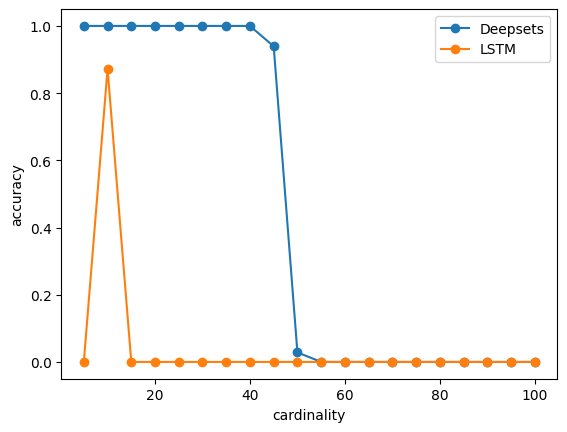

In [5]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error
import torch

#from utils import create_test_dataset
#from models import DeepSets, LSTM

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
batch_size = 64
embedding_dim = 128
hidden_dim = 64

# Generates test data
X_test, y_test = create_test_dataset()
cards = [X_test[i].shape[1] for i in range(len(X_test))]
n_samples_per_card = X_test[0].shape[0]
n_digits = 11

# Retrieves DeepSets model
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading DeepSets checkpoint!")
checkpoint = torch.load('model_deepsets.pth.tar')
deepsets.load_state_dict(checkpoint['state_dict'])
deepsets.eval()

# Retrieves LSTM model
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading LSTM checkpoint!")
checkpoint = torch.load('model_lstm.pth.tar')
lstm.load_state_dict(checkpoint['state_dict'])
lstm.eval()

# Dict to store the results
results = {'deepsets': {'acc':[], 'mae':[]}, 'lstm': {'acc':[], 'mae':[]}}

for i in range(len(cards)):
    y_pred_deepsets = list()
    y_pred_lstm = list()
    for j in range(0, n_samples_per_card, batch_size):

        ############## Task 6

        ##################
        x_batch = X_test[i][j:min(j+batch_size,n_samples_per_card),:]
        y_batch = y_test[i][j:min(j+batch_size,n_samples_per_card)]

        x_batch = torch.LongTensor(x_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)

        output_deepsets = deepsets(x_batch)
        y_pred_deepsets.append(output_deepsets)

        output_lstm = lstm(x_batch)
        y_pred_lstm.append(output_lstm)
        ##################

    y_pred_deepsets = torch.cat(y_pred_deepsets)
    y_pred_deepsets = y_pred_deepsets.detach().cpu().numpy()

    acc_deepsets = accuracy_score(y_test[i],np.round(y_pred_deepsets))#your code here
    mae_deepsets = mean_absolute_error(y_test[i], np.round(y_pred_deepsets)) #your code here
    results['deepsets']['acc'].append(acc_deepsets)
    results['deepsets']['mae'].append(mae_deepsets)

    y_pred_lstm = torch.cat(y_pred_lstm)
    y_pred_lstm = y_pred_lstm.detach().cpu().numpy()

    acc_lstm = accuracy_score(y_test[i],np.round(y_pred_lstm)) #your code here
    mae_lstm = mean_absolute_error(y_test[i],np.round(y_pred_lstm))#your code here
    results['lstm']['acc'].append(acc_lstm)
    results['lstm']['mae'].append(mae_lstm)


############## Task 7

##################
plt.plot(cards,results["deepsets"]["acc"],"-o",label="Deepsets")
plt.plot(cards,results["lstm"]["acc"],"-o",label="LSTM")
plt.xlabel("cardinality")
plt.ylabel("accuracy")
plt.legend()
plt.show()
##################